## Exploring Machine Learning Basics

by implementing a k-nearest neighbors classifier and applying it to the iris dataset.

The k-nearest neighbors algorithm classifies an object by calculating the distance to the objects given in the trainingdata. Then the closest objects are considered and the class of the unknown object is determined based on them.

The objects are represented as 'feature-vectors', lists of numbers, where every number describes some measure of the object. Two feature-vectors can be compared by calculating the distance between them. 

Chossing the distance metric is somewhat arbitrary - the euclidean distance seems to be common. 

The *k* in the algorithm name stands for an integer. It determines how many close objects will be considered for coming up with a classification of the new object. Classifications with small *k*'s tend to be more affected by noise in the trainingdata, while large *k*'s might miss minute patterns in the data, if there is not enough data to support it.

In [1]:
%matplotlib inline
from collections import Counter
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Iris Dataset

The iris dataset contains data describing the width and height of sepal and petal of three types of irises' - Setosa, Versicolour, and Virginica. More information can be foundon the [Scikit-learn page](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [12]:
iris = datasets.load_iris()

### Train Test Split

Evaluating the classifier by having it classify the training data is usually a bad idea, because one will not be able to detect [overfitting](https://en.wikipedia.org/wiki/Overfitting)

For a nearest neighbor classifier this is particulary relevant, as there always exists an object with zero distance in the trainingdata already.

A train-test-split randomly shuffles the training data and then uses a fraction of it for training and the rest for testing the classifier. The test-data should be more representative of real-world-data the classifier will encouter later on.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.25)
# number of training and testing examples
len(x_train), len(x_test)

(112, 38)

### KNN Implementation

In [4]:
class Knn:
    def __init__(self, k=5):
        """
        k-nearest-neighbor classifier. The programming interface is
        based on scikit-learn, featuring 'fit(X, y)' to train the classifier
        and 'predict(X)' to get predictions from the algoithm.
        
        Parameters
        ----------
        k : positive integer
            the number of objects to be considered for 
            majority vote during classification.
        
        Example
        -------
        >>> clf = Knn(5)
        ### Provide training data
        >>> clf.fit(X, y)
        ### Get predictions from the classifier
        >>> clf.predict(Y) # -> returns y'
        """
        if k <= 0:
            raise ValueError("Knn parameter 'k' must be positive")
        self._k = int(k)
        
    def _majority_vote(self, idx):
        """
        Given the indexes of the k nearet neighbors
            determine the corresponding labels and
            count how often they are present within 
            the neighborhood return the most frequent 
            label
        
        Parameters
        ----------
        idx : array-like
            every element of idx should be a valid index into self._X.
            
        Returns
        -------
        y : label (element of self._y)
            The element of self._y that is most frequent within the selected
            indices.
        """
        ctr = Counter(self._y[idx])
        # Counter.most_common returns a list of the '1' most common object
        # every entry of the list is a two-tuple with (object, count)
        return ctr.most_common(1)[0][0]
        
    def fit(self, X, y):
        """ 'Fit' the classifier to the data. For a knn this means
            keeping a copy of it around for later reference.
        
        Parameters
        ----------
        X : array-like
            array containing the featurevectors of every object
        y : array-like
            array containing the labels of every object
        
            for any 'i' X[i] should correspond to y[i].
            
        Returns
        -------
        None
        
        Complexity
        ----------
            O(n)
        """
        # the array constructor will ensure the existance of 
        # numpy arrays within this instance and will create a 
        # copy of the trianing data to be uneffected by future
        # 'outside' manipulations
        self._X = np.array(X)
        self._y = np.array(y)
        return self
    
    def predict(self, X, k = None):
        """ 'Predict' a label for every object and return it.
                
        Parameters
        ----------
        X : array-like
            array containing the featurevectors of every object
            
        Returns
        -------
        y : array-like
            array containing the labels of every object
            for any 'i' X[i] will correspond to y[i].
    
        
        Complexity
        ----------
            O(n)
        """
        if k is None:
            k = self._k
        
        out = []
        # ensure that iterating over the first axis yields feature
        # vectors and not elements from the feature vector
        # (necessary when X is a single feature vector)
        X = np.atleast_2d(X)
        
        for x in X:
            # given a single example (x)
            # determine the label of the example
            # based on majority vote of the nearest neighbors

            dist = np.linalg.norm(self._X - x, axis=1)
            # get the indexes of the k smallest instances
            idx = np.argsort(dist)[:k]
            # pass the nearest neighbors to the majority vote
            # determines the label
            out.append(self._majority_vote(idx))
        return np.array(out)

### Evaluating Accuracy and Overfitting

In [14]:
clf = Knn(k=5)
clf.fit(x_train, y_train)

# KNN (k=5) Accuracy on test data
np.mean(clf.predict(x_test) == y_test)

1.0

In [15]:
# KNN (k=5) Accuracy on training data
np.mean(clf.predict(x_train) == y_train)

0.9732142857142857

There is little difference between trainig and testing accuracy. Overfitting appears to be a little problem. To further investigate the question, we will consider multiple values of k inbetween 1 and 100 and compare the accuracy.

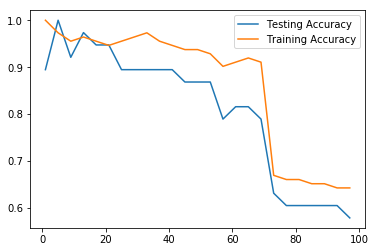

In [16]:
acc_train, acc_test = [], []
r = range(1, 100, 4)
for k in r:
    acc_test.append(np.mean(clf.predict(x_test, k) == y_test))
    acc_train.append(np.mean(clf.predict(x_train, k) == y_train))
    

plt.plot(r, acc_test)
plt.plot(r, acc_train)
plt.legend(['Testing Accuracy', 'Training Accuracy'])

With this dataset, the best choice of k seems to be between 1 and 10. The testing accuracy surpasses the training accuracy for certain values of k lower than 20, indicating that overfitting should not significantly impact our classification accuracy. 

For three possible classes, a random classification would be expected to get an accuracy of 0.33. For increasing values of k, this  KNN classifier degrades towards random performance.

### Explore the error's made

[[ 10.   0.   0.]
 [  0.  14.   3.]
 [  0.   0.  11.]]


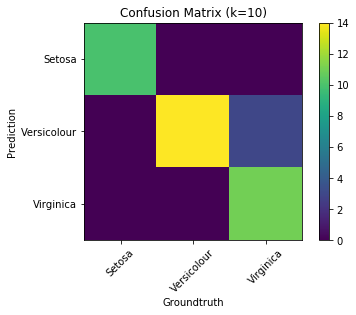

In [26]:
classes = ["Setosa", "Versicolour", "Virginica"]
confusion = np.zeros((3,3))
for x, y in zip(x_test, y_test):
    confusion[clf.predict(x, k=10), y] += 1
print(confusion)
    
plt.imshow(confusion, interpolation='nearest')
plt.title("Confusion Matrix (k=10)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.xlabel('Groundtruth')
plt.yticks(tick_marks, classes)
plt.ylabel('Prediction')

The error look to be predictions of versicolour when virginicia is the groundtruth.

In [ ]:
# TODO plot the decision plane somehow
